In [10]:
using Flux, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle
using Base.Iterators: repeated, partition
using Printf, BSON
using MLDatasets
using Downloads
using NPZ
using Images, Colors
using BenchmarkTools

In [11]:
train_dict = npzread("KMNIST/kmnist-train-imgs.npz")
train_labels = npzread("KMNIST/kmnist-train-labels.npz")
test_dict = npzread("KMNIST/kmnist-test-imgs.npz")
test_labels = npzread("KMNIST/kmnist-test-labels.npz");

In [12]:
train_y = convert(Vector{Int64}, train_labels["arr_0"])
test_y = convert(Vector{Int64}, test_labels["arr_0"])

train_x = convert(Array{Float32}, train_dict["arr_0"])/255
train_x = permutedims(train_x, (2,3,1))
train_x = reshape(train_x, (28,28,1,60000))
print(size(train_x))

test_x = convert(Array{Float32}, test_dict["arr_0"])/255
test_x = permutedims(test_x, (2,3,1))
test_x = reshape(test_x, (28,28,1,10000))
print(size(test_x))

(28, 28, 1, 60000)(28, 28, 1, 10000)

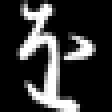

In [37]:
a = test_x[:,:,1,2]
Gray.(a)

In [43]:
print(test_y[2])

9

In [13]:
labels = ["o", "ki", "su", "tsu", "na", "ha", "ma", "ya", "re", "wo"]

10-element Vector{String}:
 "o"
 "ki"
 "su"
 "tsu"
 "na"
 "ha"
 "ma"
 "ya"
 "re"
 "wo"

In [19]:
train_set = Flux.DataLoader((train_x[:,:,:,1:100],train_y[1:100]), shuffle=true, batchsize=1)

100-element DataLoader(::Tuple{Array{Float32, 4}, Vector{Int64}}, shuffle=true)
  with first element:
  (28×28×1×1 Array{Float32, 4}, 1-element Vector{Int64},)

In [14]:
function prepare_model()
    @info("Constructing model...")
    model = Chain(
        Conv((5, 5), 1=>20, pad=(0,0), relu),
        x -> maxpool(x, (2,2)),

        Conv((5, 5), 20=>50, pad=(0,0), relu),
        x -> maxpool(x, (2,2)),

        #x -> reshape(x, :, size(x, 4)),
        x -> Flux.flatten(x),
        Dense(800, 500),
        Dense(500, 10),

        softmax,
    )
    return model
end

prepare_model (generic function with 1 method)

In [6]:
model = prepare_model()

[ Info: Constructing model...


Chain(
  Conv((5, 5), 1 => 20, relu),          # 520 parameters
  var"#1#4"(),
  Conv((5, 5), 20 => 50, relu),         # 25_050 parameters
  var"#2#5"(),
  var"#3#6"(),
  Dense(800 => 500),                    # 400_500 parameters
  Dense(500 => 10),                     # 5_010 parameters
  NNlib.softmax,
)                   # Total: 8 arrays, 431_080 parameters, 1.645 MiB.

In [62]:
c = Conv((3,3), 1=>20, pad=(1,1), relu)
Flux.outputsize(c, (28, 28, 1, 32))  # returns (13, 13, 5, 32)

(28, 28, 20, 32)

In [15]:
function loss(result, label)
	return Flux.crossentropy(result,Flux.onehotbatch(label,0:9))
end

loss (generic function with 1 method)

In [16]:
function accuracy(model)
    correct = 0
    for index in 1:length(test_y)
        probs = model(Flux.unsqueeze(test_x[:,:,:,index],dims=3))
        predicted_digit = argmax(probs)[1]-1
        if predicted_digit == test_y[index]
            correct +=1
        end
    end
    return correct/length(test_y)
end

accuracy (generic function with 1 method)

In [17]:
function train(model, opt_params, train_set)
    my_log = []
    for epoch in 1:3
      losses = Float32[]
      for (i, data) in enumerate(train_set)
        input, label = data

        val, grads = Flux.withgradient(model) do m

          result = m(input)
          loss(result, label)
        end

        push!(losses, val)

        if !isfinite(val)
          @warn "loss is $val on item $i" epoch
          continue
        end

        Flux.update!(opt_params, model, grads[1])
      end

      acc = accuracy(model)
      push!(my_log, (; acc, losses))

      println("Epoch $epoch finished with accuracy: $acc")
    end
end

train (generic function with 1 method)

In [10]:
BenchmarkTools.DEFAULT_PARAMETERS.samples = 1
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 200

times = zeros(20)
memory = zeros(20)

num = 1
for i in 100:100:2000
    train_set = Flux.DataLoader((train_x[:,:,:,1:i],train_y[1:i]), shuffle=true, batchsize=1)
    model = prepare_model()
    opt_state = Flux.setup(Adam(), model)
    b = @benchmark train($model, $opt_state, $train_set) samples = 2 evals = 1 seconds = 100
    b = mean(b)
    times[num] = b.time * 10e-10 
    memory[num] = b.memory * 9.31*10e-11
    num += 1
end

println(times)
println(memory)

[ Info: Constructing model...


Epoch 1 finished with accuracy: 0.2876
Epoch 2 finished with accuracy: 0.4
Epoch 3 finished with accuracy: 0.4595
Epoch 1 finished with accuracy: 0.4736
Epoch 2 finished with accuracy: 0.4279
Epoch 3 finished with accuracy: 0.464
Epoch 1 finished with accuracy: 0.4835
Epoch 2 finished with accuracy: 0.4944
Epoch 3 finished with accuracy: 0.4942


[ Info: Constructing model...


Epoch 1 finished with accuracy: 0.3831
Epoch 2 finished with accuracy: 0.417
Epoch 3 finished with accuracy: 0.5259
Epoch 1 finished with accuracy: 0.5498
Epoch 2 finished with accuracy: 0.5626
Epoch 3 finished with accuracy: 0.5754
Epoch 1 finished with accuracy: 0.541
Epoch 2 finished with accuracy: 0.5458
Epoch 3 finished with accuracy: 0.5613


[ Info: Constructing model...


Epoch 1 finished with accuracy: 0.5222
Epoch 2 finished with accuracy: 0.6014
Epoch 3 finished with accuracy: 0.5875
Epoch 1 finished with accuracy: 0.5672
Epoch 2 finished with accuracy: 0.6459
Epoch 3 finished with accuracy: 0.5501
Epoch 1 finished with accuracy: 0.6475
Epoch 2 finished with accuracy: 0.6606
Epoch 3 finished with accuracy: 0.6612


[ Info: Constructing model...


Epoch 1 finished with accuracy: 0.5904
Epoch 2 finished with accuracy: 0.6001
Epoch 3 finished with accuracy: 0.6192
Epoch 1 finished with accuracy: 0.6756
Epoch 2 finished with accuracy: 0.6052
Epoch 3 finished with accuracy: 0.6738
Epoch 1 finished with accuracy: 0.6382
Epoch 2 finished with accuracy: 0.6101
Epoch 3 finished with accuracy: 0.6639


[ Info: Constructing model...


Epoch 1 finished with accuracy: 0.5535
Epoch 2 finished with accuracy: 0.628
Epoch 3 finished with accuracy: 0.6406
Epoch 1 finished with accuracy: 0.6658
Epoch 2 finished with accuracy: 0.6933
Epoch 3 finished with accuracy: 0.6776
Epoch 1 finished with accuracy: 0.6726
Epoch 2 finished with accuracy: 0.7025
Epoch 3 finished with accuracy: 0.7012


[ Info: Constructing model...


Epoch 1 finished with accuracy: 0.4801
Epoch 2 finished with accuracy: 0.5995
Epoch 3 finished with accuracy: 0.6481
Epoch 1 finished with accuracy: 0.62
Epoch 2 finished with accuracy: 0.6409
Epoch 3 finished with accuracy: 0.6574
Epoch 1 finished with accuracy: 0.6378
Epoch 2 finished with accuracy: 0.6068
Epoch 3 finished with accuracy: 0.6293


[ Info: Constructing model...


Epoch 1 finished with accuracy: 0.5414
Epoch 2 finished with accuracy: 0.5614
Epoch 3 finished with accuracy: 0.5544
Epoch 1 finished with accuracy: 0.6226
Epoch 2 finished with accuracy: 0.6408
Epoch 3 finished with accuracy: 0.6375
Epoch 1 finished with accuracy: 0.6561
Epoch 2 finished with accuracy: 0.6759
Epoch 3 finished with accuracy: 0.6396


[ Info: Constructing model...


Epoch 1 finished with accuracy: 0.6282
Epoch 2 finished with accuracy: 0.6066
Epoch 3 finished with accuracy: 0.6608
Epoch 1 finished with accuracy: 0.6769
Epoch 2 finished with accuracy: 0.6469
Epoch 3 finished with accuracy: 0.7051
Epoch 1 finished with accuracy: 0.7074
Epoch 2 finished with accuracy: 0.6596
Epoch 3 finished with accuracy: 0.6947


[ Info: Constructing model...


Epoch 1 finished with accuracy: 0.5363
Epoch 2 finished with accuracy: 0.6323
Epoch 3 finished with accuracy: 0.6525
Epoch 1 finished with accuracy: 0.6857
Epoch 2 finished with accuracy: 0.6643
Epoch 3 finished with accuracy: 0.6627
Epoch 1 finished with accuracy: 0.7012
Epoch 2 finished with accuracy: 0.6873
Epoch 3 finished with accuracy: 0.665


[ Info: Constructing model...


Epoch 1 finished with accuracy: 0.6526
Epoch 2 finished with accuracy: 0.6646
Epoch 3 finished with accuracy: 0.7203
Epoch 1 finished with accuracy: 0.6912
Epoch 2 finished with accuracy: 0.6643
Epoch 3 finished with accuracy: 0.704
Epoch 1 finished with accuracy: 0.7113
Epoch 2 finished with accuracy: 0.7452
Epoch 3 finished with accuracy: 0.6527


[ Info: Constructing model...


Epoch 1 finished with accuracy: 0.5898
Epoch 2 finished with accuracy: 0.688
Epoch 3 finished with accuracy: 0.6721
Epoch 1 finished with accuracy: 0.6986
Epoch 2 finished with accuracy: 0.6922
Epoch 3 finished with accuracy: 0.6964
Epoch 1 finished with accuracy: 0.7015
Epoch 2 finished with accuracy: 0.7066
Epoch 3 finished with accuracy: 0.6762


[ Info: Constructing model...


Epoch 1 finished with accuracy: 0.6426
Epoch 2 finished with accuracy: 0.6989
Epoch 3 finished with accuracy: 0.6588
Epoch 1 finished with accuracy: 0.703
Epoch 2 finished with accuracy: 0.7511
Epoch 3 finished with accuracy: 0.7283
Epoch 1 finished with accuracy: 0.7155
Epoch 2 finished with accuracy: 0.7215
Epoch 3 finished with accuracy: 0.688


[ Info: Constructing model...


Epoch 1 finished with accuracy: 0.6659
Epoch 2 finished with accuracy: 0.6968
Epoch 3 finished with accuracy: 0.6905
Epoch 1 finished with accuracy: 0.7027
Epoch 2 finished with accuracy: 0.6913
Epoch 3 finished with accuracy: 0.722
Epoch 1 finished with accuracy: 0.6958
Epoch 2 finished with accuracy: 0.7193
Epoch 3 finished with accuracy: 0.7503


[ Info: Constructing model...


Epoch 1 finished with accuracy: 0.6125
Epoch 2 finished with accuracy: 0.7253
Epoch 3 finished with accuracy: 0.7059
Epoch 1 finished with accuracy: 0.7431
Epoch 2 finished with accuracy: 0.7051
Epoch 3 finished with accuracy: 0.6998
Epoch 1 finished with accuracy: 0.731
Epoch 2 finished with accuracy: 0.7397
Epoch 3 finished with accuracy: 0.7308


[ Info: Constructing model...


Epoch 1 finished with accuracy: 0.6439
Epoch 2 finished with accuracy: 0.6994
Epoch 3 finished with accuracy: 0.7382
Epoch 1 finished with accuracy: 0.716
Epoch 2 finished with accuracy: 0.7163
Epoch 3 finished with accuracy: 0.7433
Epoch 1 finished with accuracy: 0.7269
Epoch 2 finished with accuracy: 0.7542
Epoch 3 finished with accuracy: 0.7181


[ Info: Constructing model...


Epoch 1 finished with accuracy: 0.6494
Epoch 2 finished with accuracy: 0.7139
Epoch 3 finished with accuracy: 0.6851
Epoch 1 finished with accuracy: 0.7665
Epoch 2 finished with accuracy: 0.7539
Epoch 3 finished with accuracy: 0.7463
Epoch 1 finished with accuracy: 0.7488
Epoch 2 finished with accuracy: 0.7473
Epoch 3 finished with accuracy: 0.7147


[ Info: Constructing model...


Epoch 1 finished with accuracy: 0.6748
Epoch 2 finished with accuracy: 0.7236
Epoch 3 finished with accuracy: 0.7265
Epoch 1 finished with accuracy: 0.7464
Epoch 2 finished with accuracy: 0.7433
Epoch 3 finished with accuracy: 0.7337
Epoch 1 finished with accuracy: 0.7423
Epoch 2 finished with accuracy: 0.7199
Epoch 3 finished with accuracy: 0.7548


[ Info: Constructing model...


Epoch 1 finished with accuracy: 0.6814
Epoch 2 finished with accuracy: 0.6493
Epoch 3 finished with accuracy: 0.731
Epoch 1 finished with accuracy: 0.7253
Epoch 2 finished with accuracy: 0.7258
Epoch 3 finished with accuracy: 0.7354
Epoch 1 finished with accuracy: 0.7363
Epoch 2 finished with accuracy: 0.7365
Epoch 3 finished with accuracy: 0.7385


[ Info: Constructing model...


Epoch 1 finished with accuracy: 0.6384
Epoch 2 finished with accuracy: 0.6953
Epoch 3 finished with accuracy: 0.7038
Epoch 1 finished with accuracy: 0.729
Epoch 2 finished with accuracy: 0.7557
Epoch 3 finished with accuracy: 0.7724
Epoch 1 finished with accuracy: 0.7373
Epoch 2 finished with accuracy: 0.7542
Epoch 3 finished with accuracy: 0.6837


[ Info: Constructing model...


Epoch 1 finished with accuracy: 0.6904
Epoch 2 finished with accuracy: 0.7364
Epoch 3 finished with accuracy: 0.7245
Epoch 1 finished with accuracy: 0.7356
Epoch 2 finished with accuracy: 0.7487
Epoch 3 finished with accuracy: 0.7603
Epoch 1 finished with accuracy: 0.7611
Epoch 2 finished with accuracy: 0.7402
Epoch 3 finished with accuracy: 0.7599
[26.5344015, 27.356916950000002, 29.696160600000002, 30.0919357, 32.256415350000005, 33.5704232, 35.322004, 36.821576900000004, 38.9527055, 41.06188265, 44.2727371, 45.630998600000005, 47.6514779, 49.8009512, 51.379144800000006, 53.317580050000004, 54.0447688, 55.7449859, 58.98406835, 61.35161]
[10.12143088796, 10.873601473448002, 11.625764566248002, 12.377925782152001, 13.130089381416001, 13.882266789272, 14.634447593416, 15.386647911320003, 16.138829311304, 16.891009504712, 17.643191277096, 18.395370978936, 19.147551574536003, 19.899732780872, 20.651913465848, 21.404092899560002, 22.156273644120002, 22.908453748152002, 23.660679776552, 24.

In [ ]:
BenchmarkTools.DEFAULT_PARAMETERS.samples = 1
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 100

times = zeros(20)
memory = zeros(20)

num = 1
for i in 3000:1000:10000
    train_set = Flux.DataLoader((train_x[:,:,:,1:i],train_y[1:i]), shuffle=true, batchsize=1)
    model = prepare_model()
    opt_state = Flux.setup(Adam(), model)
    b = @benchmark train($model, $opt_state, $train_set) samples = 2 evals = 1 seconds = 60
    b = mean(b)
    times[num] = b.time * 10e-10 
    memory[num] = b.memory * 9.31*10e-11
    print(times[num])
    print(memory[num])
    num += 1
end

println(times)
println(memory)

[ Info: Constructing model...


Epoch 1 finished with accuracy: 0.7353
Epoch 2 finished with accuracy: 0.778
Epoch 3 finished with accuracy: 0.7665
Epoch 1 finished with accuracy: 0.7802
Epoch 2 finished with accuracy: 0.7971
Epoch 3 finished with accuracy: 0.7884
77.488025531.934673336720003

[ Info: Constructing model...


Epoch 1 finished with accuracy: 0.7592
Epoch 2 finished with accuracy: 0.7844
Epoch 3 finished with accuracy: 0.7998
Epoch 1 finished with accuracy: 0.7838
Epoch 2 finished with accuracy: 0.7953
Epoch 3 finished with accuracy: 0.8149
96.8835395000000139.456468470776

[ Info: Constructing model...


Epoch 1 finished with accuracy: 0.7198
Epoch 2 finished with accuracy: 0.7755
Epoch 3 finished with accuracy: 0.7829
Epoch 1 finished with accuracy: 0.7859
Epoch 2 finished with accuracy: 0.8132
Epoch 3 finished with accuracy: 0.8052
115.729479646.978370520872005

[ Info: Constructing model...


Epoch 1 finished with accuracy: 0.7857
Epoch 2 finished with accuracy: 0.7442
Epoch 3 finished with accuracy: 0.828
Epoch 1 finished with accuracy: 0.8184
Epoch 2 finished with accuracy: 0.8008
Epoch 3 finished with accuracy: 0.8136
134.81720754.500185839008005

[ Info: Constructing model...


Epoch 1 finished with accuracy: 0.7758
Epoch 2 finished with accuracy: 0.8057
Epoch 3 finished with accuracy: 0.835
Epoch 1 finished with accuracy: 0.8113
Epoch 2 finished with accuracy: 0.8174
Epoch 3 finished with accuracy: 0.8255
152.7367894000000262.021989828736004

[ Info: Constructing model...


Epoch 1 finished with accuracy: 0.718
Epoch 2 finished with accuracy: 0.7814
Epoch 3 finished with accuracy: 0.7891
Epoch 1 finished with accuracy: 0.8413
Epoch 2 finished with accuracy: 0.8097
Epoch 3 finished with accuracy: 0.8132
170.298487769.54378407648001

[ Info: Constructing model...


Epoch 1 finished with accuracy: 0.8122


In [48]:
BenchmarkTools.DEFAULT_PARAMETERS.samples = 1
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 100
opt_state = Flux.setup(Adam(), model)
b = @benchmark train($model, $opt_state, $train_set) samples = 2 evals = 1


Epoch 1 finished with accuracy: 0.5011
Epoch 2 finished with accuracy: 0.5017
Epoch 3 finished with accuracy: 0.5016
Epoch 1 finished with accuracy: 0.5015
Epoch 2 finished with accuracy: 0.5019
Epoch 3 finished with accuracy: 0.502
Epoch 1 finished with accuracy: 0.5024
Epoch 2 finished with accuracy: 0.5028
Epoch 3 finished with accuracy: 0.5034


BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  22.820 s …  22.890 s  ┊ GC (min … max): 2.92% … 2.82%
 Time  (median):     22.855 s              ┊ GC (median):    2.87%
 Time  (mean ± σ):   22.855 s ± 49.680 ms  ┊ GC (mean ± σ):  2.87% ± 0.07%

  █                                                        █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  22.8 s         Histogram: frequency by time         22.9 s <

 Memory estimate: 10.12 GiB, allocs estimate: 3908966.

In [65]:
mean(b)

BenchmarkTools.TrialEstimate: 
  time:             22.855 s
  gctime:           655.934 ms (2.87%)
  memory:           10.12 GiB
  allocs:           3908966

In [72]:
mean(b).time * 10e-10 # ns

22.855108700000002

In [70]:
mean(b).memory *  9.31*10e-11  #bytes

10.121429383464001

In [88]:
for i in 1:length(my_log)
    println("Acc: ", my_log[i].acc, "      Loss: ", mean(my_log[i].losses))
end  

Acc: 0.9054      Loss: 0.16691786
Acc: 0.9161      Loss: 0.0820222
Acc: 0.9207      Loss: 0.07099748
Acc: 0.9214      Loss: 0.06576953
Acc: 0.9235      Loss: 0.060587935
Acc: 0.9266      Loss: 0.05792978
Acc: 0.9256      Loss: 0.05345809
Acc: 0.9276      Loss: 0.050454166
Acc: 0.9275      Loss: 0.04473641
Acc: 0.9302      Loss: 0.041718017


Float32[4.1362553f-9; 5.082788f-7; 0.0013027663; 1.1742464f-8; 3.6631095f-6; 0.00058181665; 0.998111; 9.30122f-8; 1.3252418f-7; 4.2737853f-9;;]
Real: ma         Prediction: ma


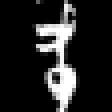

In [90]:
id = 364

predict = model(Flux.unsqueeze(test_x[:,:,:,id],dims=3))

println(predict)
println("Real: ", labels[test_y[id]+1], "         Prediction: ", labels[argmax(predict)[1]])
a = test_x[:,:,1,id]
Gray.(a)